In [1]:
import pathlib

import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr

# From UAV orthomosaic and vector data labels to training data

## Introduction

This notebook illustrates how to generate cutouts employed to train a ML-based model from a UAV orthomosaic and a set of labels that are provided as a vector data file. Note that While we focus here on trees and extract airborne tree images with the goal of training a tree species classifier, the procedure is generic and can be applied to other objects as well.

The object extraction is carried out by the `geocoded_object_extractor` tool provided in this repository. Uncomment and run the following cell in order to installing it and its dependencies in your environment:

In [2]:
# ! cd ../packages/geocoded_object_extractor && pip install .

In [3]:

from geocoded_object_extractor import ObjectExtractor
from geocoded_object_extractor.utils import write_cutouts

We define the paths to the UAV orthomosaic image and the tree labels:

In [4]:

data_path = pathlib.Path('../data')
image_path = data_path / 'Fieldwork_data/PNM/PROCESSADOS/Map1_Orthomosaic_export_SatJun10172428194829.tif'
tree_locations_path = data_path / 'Tree_location1.gpkg'

## Loading the labels

We start by loading the tree crown boundaries and the corresponding labels. In this example, the geometries have been created manually, using a GIS software (e.g. QGIS) to draw crown boundaries on the UAV orthomosaic, but they could have been generated automatically via an object detection model. See [this notebook](./TODO) on how to run [the DeepForest tree crown object deterction model](https://deepforest.readthedocs.io/en/latest/landing.html) on airborne imagery.  

In [5]:
tree_locations = gpd.read_file(tree_locations_path)
tree_locations

,ID,ESPECIE,TIPO,SELECIONADA PROJETO,geometry
0,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331065.955 7366756.421, 331065.955 7..."
1,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331068.069 7366779.140, 331068.069 7..."
2,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331075.623 7366793.023, 331075.623 7..."
3,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331088.034 7366814.640, 331088.034 7..."
4,0.0,,,,"POLYGON ((331075.083 7366789.479, 331075.316 7..."
5,0.0,,,,"POLYGON ((331071.486 7366796.598, 331071.648 7..."
6,0.0,,,,"POLYGON ((331127.154 7366835.563, 331127.465 7..."
7,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331133.179 7366823.083, 331133.179 7..."
8,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331196.087 7366842.868, 331196.087 7..."
9,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331196.075 7366878.784, 331196.075 7..."


We may use the tree species (column *ESPECIE*) as labels. We first perform some data cleaning, replacing empty strings with missing values. We then select the only trees for which a species is provided - these are the ones for which we will extract cutouts from the orthomosaic:

In [6]:
tree_locations['ESPECIE'] = tree_locations['ESPECIE'] \
    .replace(['', ' '], value=None)
mask = tree_locations['ESPECIE'].notnull()
tree_locations_with_labels = tree_locations[mask]
tree_locations_with_labels

,ID,ESPECIE,TIPO,SELECIONADA PROJETO,geometry
0,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331065.955 7366756.421, 331065.955 7..."
1,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331068.069 7366779.140, 331068.069 7..."
2,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331075.623 7366793.023, 331075.623 7..."
3,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331088.034 7366814.640, 331088.034 7..."
7,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331133.179 7366823.083, 331133.179 7..."
8,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331196.087 7366842.868, 331196.087 7..."
9,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331196.075 7366878.784, 331196.075 7..."
10,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331197.649 7366907.473, 331197.649 7..."
11,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331201.764 7366898.142, 331201.764 7..."
25,NaN,Araucaria angustifolia,ameacada,SIM,"POLYGON ((331278.924 7366884.942, 331278.924 7..."


## Extracting the cutouts (training data)

We then move on to extract the cutouts from the UAV image using the tree crown geometries. Note that if the orthomosaic is provided as multiple tiles, we can pass the list of tile paths as input to the `ObjectExtractor` (`images=['tile_path1', 'tile_path2, ...]`). We also specify the side (in pixels) of the generated cutouts (180 here), smaller cutouts will be zero-padded to match the desired size. Finally, we convert non-numeric labels to a numeric format (0, 1, ...) by setting `encode_labels=True`.

In [7]:
geoms = tree_locations_with_labels.geometry
labels = tree_locations_with_labels['ESPECIE']

obj_extr = ObjectExtractor(
    images=[image_path],
    geoms=geoms,
    labels=labels,
    pixel_size=180,
    encode_labels=True
)

labels, transform_params, crs, cutouts = obj_extr.get_cutouts()

The method `get_cutouts()` returns the cutouts stacked in an array of shape (nsamples, ny, nx, nchannels), the corresponding labels, and information on the cutouts' Affine transformation parameters and CRS. The last two elements are necessary to geo-locate the cutouts extracted from the image.

Let's plot out a selection of the cutouts:

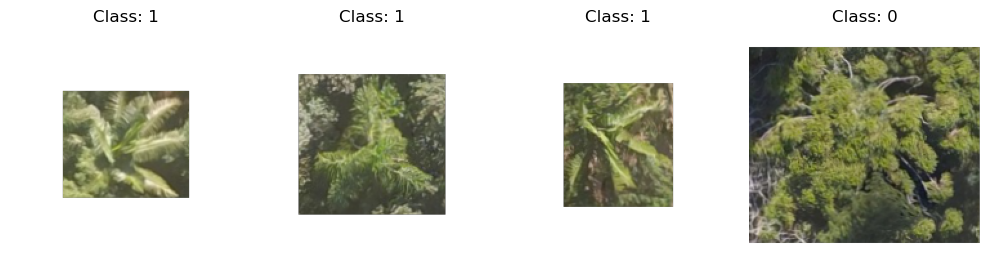

In [8]:
num_samples = 4  # plot 4 cutouts
fig, ax = plt.subplots(1, num_samples, figsize=(10, 3))
for nplot, ncutout in enumerate(range(0, len(cutouts), len(cutouts)//num_samples + 1)):
    ax[nplot].imshow(cutouts[ncutout])
    ax[nplot].set_axis_off()
    ax[nplot].set_title(f'Class: {labels.iloc[ncutout]}')
fig.tight_layout()

## Saving the cutouts 

If we do not need to geo-locate the cutouts, we can drop this information and store the cutouts and their labels in a format that is suitable for multi-dimensional arrays, such as HDF5 or Zarr:

In [9]:
# create a Dataset and add cutouts and labels to it
ds = xr.Dataset(
    data_vars={
        'X': (['sample', 'x', 'y', 'channel'], cutouts),
        'Y': (['sample'], labels),
    }
)

# save the Dataset in Zarr format
ds.to_zarr('./cutouts.zarr', mode='w')

If we do not want to discard the geo-location of the cutouts, we can use the following utility function of the object extractor tool to save cutouts and labels as a set of GeoTIFFs. Note that the labels, together with the cutout IDs, are stored as attributes inside the GeoTIFF files: 

In [10]:
write_cutouts(cutouts, crs, transform_params, outdir="./cutouts", overwrite=True)

In [11]:
! ls -lha ./cutouts

total 1104
drwxr-xr-x  15 fnattino  staff   480B Apr 12 01:00 .
drwxr-xr-x   9 fnattino  staff   288B Apr 12 01:00 ..
-rw-r--r--   1 fnattino  staff    32K Apr 12 01:00 cutout-00001.tif
-rw-r--r--   1 fnattino  staff    24K Apr 12 01:00 cutout-00002.tif
-rw-r--r--   1 fnattino  staff    12K Apr 12 01:00 cutout-00003.tif
-rw-r--r--   1 fnattino  staff    31K Apr 12 01:00 cutout-00004.tif
-rw-r--r--   1 fnattino  staff    45K Apr 12 01:00 cutout-00005.tif
-rw-r--r--   1 fnattino  staff    34K Apr 12 01:00 cutout-00006.tif
-rw-r--r--   1 fnattino  staff    36K Apr 12 01:00 cutout-00007.tif
-rw-r--r--   1 fnattino  staff    27K Apr 12 01:00 cutout-00008.tif
-rw-r--r--   1 fnattino  staff    33K Apr 12 01:00 cutout-00009.tif
-rw-r--r--   1 fnattino  staff    32K Apr 12 01:00 cutout-00010.tif
-rw-r--r--   1 fnattino  staff    38K Apr 12 01:00 cutout-00011.tif
-rw-r--r--   1 fnattino  staff    82K Apr 12 01:00 cutout-00012.tif
-rw-r--r--   1 fnattino  staff   100K Apr 12 01:00 cutout-00013.ti